# Random Forest Model

- Plot graphs showing training performance as a function of parameters

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pandas
import numpy
import itertools
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import log_loss
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB

In [3]:
import loan_approval_lib
from loan_approval_lib import logspace, linspace

In [4]:
from kaggle_wrapper_lib import kaggle_competition_submit
from kaggle_wrapper_lib import kaggle_competition_submissions

In [5]:
from loan_approval_lib.standard_data_processing import data_cleaning_algorithm
from loan_approval_lib.standard_data_processing import create_loan_grade_numerical_from_loan_grade
from loan_approval_lib.standard_data_processing import create_person_home_ownership_one_hot_encoder
from loan_approval_lib.standard_data_processing import create_person_home_ownership_one_hot
from loan_approval_lib.standard_data_processing import create_loan_intent_one_hot_encoder
from loan_approval_lib.standard_data_processing import create_loan_intent_one_hot
from loan_approval_lib.standard_data_processing import map_cb_person_default_on_file
from loan_approval_lib.standard_data_processing import create_decision_tree_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns_with_id
from loan_approval_lib.standard_data_processing import create_dataframe_copy_and_drop_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns_with_id

In [6]:
#import warnings
#from sklearn.exceptions import UserWarning
#warnings.filterwarnings(action='ignore', category=UserWarning)

In [7]:
data = loan_approval_lib.load_original_data()

In [8]:
data_train = loan_approval_lib.load_data_train()

In [9]:
data_test = loan_approval_lib.load_data_test()

# Data Cleaning, Data Preprocessing

In [10]:
data = data_cleaning_algorithm(data)

column person_age, number of removed rows: 5
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 897
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 3047
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [11]:
data_train = data_cleaning_algorithm(data_train)

column person_age, number of removed rows: 1
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 2
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 0
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [12]:
data_cleaning_algorithm(data_test)
None

column person_age, number of removed rows: 0
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 0
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 0
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [13]:
# Loan Grade

create_loan_grade_numerical_from_loan_grade(data, data_train, data_test)

In [14]:
# Person Home Ownership

encoder = create_person_home_ownership_one_hot_encoder(data)

data = create_person_home_ownership_one_hot(encoder, data)
data_train = create_person_home_ownership_one_hot(encoder, data_train)
data_test = create_person_home_ownership_one_hot(encoder, data_test)

In [15]:
# Loan Intent

encoder = create_loan_intent_one_hot_encoder(data)

data = create_loan_intent_one_hot(encoder, data)
data_train = create_loan_intent_one_hot(encoder, data_train)
data_test = create_loan_intent_one_hot(encoder, data_test)

In [16]:
# Default On File

data = map_cb_person_default_on_file(data)
data_train = map_cb_person_default_on_file(data_train)
data_test = map_cb_person_default_on_file(data_test)

# Choose Columns for Tree Model, Copy DataFrame and Drop Unused Columns

In [17]:
decision_tree_columns = create_decision_tree_columns()
decision_tree_columns_with_id = create_decision_tree_columns_with_id()

In [18]:
data_copy = create_dataframe_copy_and_drop_columns(data)
data_train_copy = create_dataframe_copy_and_drop_columns(data_train)
data_test_copy = create_dataframe_copy_and_drop_columns(data_test)

# Random Forest Model

In [19]:
def random_forest_model_train(
    data_train,
    decision_tree_columns,
    n_estimators,
    max_features,
    max_depth,
    min_samples_split,
    min_samples_leaf,
    bootstrap,
    n_jobs,
):

    X = data_train[decision_tree_columns].copy()
    Y = data_train['loan_status'].copy()
    
    clf = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        criterion='entropy',
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        n_jobs=n_jobs,
        oob_score=True,
        
    )
    clf.fit(X, Y)
    
    Z = clf.predict(X)
    X['loan_status_predict'] = Z
    X['loan_status'] = data_train['loan_status']
    accuracy_in_sample = (X['loan_status'] == X['loan_status_predict']).sum() / len(X)
    
    return (clf, accuracy_in_sample)

In [20]:
def random_forest_model_test(
    clf,
    data_test,
    decision_tree_columns,
):

    X_test = data_test[decision_tree_columns].copy()

    Z_test = clf.predict(X_test)
    X_test['loan_status_predict'] = Z_test
    X_test['loan_status'] = data_test['loan_status']
    accuracy_out_of_sample = (X_test['loan_status'] == X_test['loan_status_predict']).sum() / len(X_test)
    
    return accuracy_out_of_sample

In [21]:
def random_forest_model_predict(
    clf,
    data_predict,
    decision_tree_columns,
    decision_tree_columns_with_id,
):
    
    X_predict = data_predict[decision_tree_columns_with_id].copy()

    Z_predict = clf.predict_proba(X_predict[decision_tree_columns])
    X_predict['loan_status'] = Z_predict[:, 1]

    return X_predict

In [22]:
def random_forest_model_predict_write_to_csv(
    data_predict,
    filename,
):
    data_predict[['id', 'loan_status']].to_csv(filename, index=False)

# Optimize Choice of Dataset

In [23]:
len(data_copy), len(data_train_copy), len(data_test_copy)

(28632, 58642, 39098)

In [24]:
'loan_status' in data_copy.columns, 'loan_status' in data_train_copy.columns, 'loan_status' in data_test_copy

(True, True, False)

In [25]:
28632 + 58642

87274

In [26]:
all_training_data = pandas.concat(
    [data_copy, data_train_copy],
    axis=0,
)
all_training_data.reset_index(inplace=True, drop=True)

In [27]:
permutation = numpy.random.permutation(all_training_data.index)

In [28]:
n_samples = len(all_training_data)
n_samples

87274

In [29]:
k = 100

In [30]:
fold_sizes = numpy.full(k, n_samples // k, dtype=int)
fold_sizes

array([872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872])

In [31]:
fold_sizes[:n_samples % k] += 1
fold_sizes

array([873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872])

In [32]:
index = 0
folds = []
for fold_size in fold_sizes:
    start = index
    stop = index + fold_size
    folds.append(permutation[start:stop])
    index = stop

In [33]:
def kaggle_competition_submit_and_get_public_private_score_sync(filename, message):
    
    _ = kaggle_competition_submit(
        filename,
        message_tag
    )

    # TODO: Can make this faster with async logic
    while True:
        submissions = kaggle_competition_submissions()
        filtered_submissions = submissions[submissions['description'] == message_tag]
        assert len(filtered_submissions) == 1, f'invalid number of filtered submissions {len(filtered_submissions)}'
        status = filtered_submissions['status'][0]
        if status == 'SubmissionStatus.COMPLETE':
            break
        elif status == 'SubmissionStatus.PENDING':
            pass
        else:
            print(f'status={status}')

    public_score = filtered_submissions['publicScore'][0]
    private_score = filtered_submissions['privateScore'][0]

    return (public_score, private_score)

In [72]:
n_estimators_list = []
n_min_samples_split_list = []
n_min_samples_leaf_list = []
n_features_list = []
accuracy_in_sample_list = []
accuracy_out_of_sample_list = []
oob_score_list = []
public_score_list = []
private_score_list = []

n_estimators = 100
n_min_samples_split = 10
n_features = 'sqrt'
n_cpu = 16

# for n_features in ['sqrt', 'log2', None]
# for n_estimators in 

#n_min_samples_leaf_list_input = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20]
n_min_samples_leaf_list_input = [1]

for n_features in ['sqrt', None]: #['sqrt', 'log2', None]:
    print(f'processing n_features={n_features}')
    for n_min_samples_leaf in n_min_samples_leaf_list_input:
        print(f'processing n_features={n_features}, n_min_samples_leaf={n_min_samples_leaf}')
        for i in range(k):
            test_index = folds[i]
            train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
        
            training_data = all_training_data.loc[train_index]
            test_data = all_training_data.loc[test_index]
            
            (
                clf,
                accuracy_in_sample,
            ) = random_forest_model_train(
                training_data,
                decision_tree_columns,
                n_estimators,
                n_features,
                None,
                n_min_samples_split,
                n_min_samples_leaf,
                True,
                n_cpu,
            )
        
            oob_score_ = clf.oob_score_
        
            accuracy_out_of_sample = random_forest_model_test(
                clf,
                test_data,
                decision_tree_columns,
            )
        
            n_estimators_list.append(n_estimators)
            n_min_samples_split_list.append(n_min_samples_split)
            n_min_samples_leaf_list.append(n_min_samples_leaf)
            n_features_list.append(n_features)
            accuracy_in_sample_list.append(accuracy_in_sample)
            accuracy_out_of_sample_list.append(accuracy_out_of_sample)
            oob_score_list.append(oob_score_)
        
            data_predict = random_forest_model_predict(
                clf,
                data_test_copy,
                decision_tree_columns,
                decision_tree_columns_with_id,
            )

            public_score = numpy.nan
            private_score = numpy.nan
            
            if False:
                filename = f'random_forest_model_features_{n_features}_estimators_{n_estimators}_fold_{i}_test.csv'
                message_tag = f'AUTO_TEST_random_forest_model_features_{n_features}_estimators_{n_estimators}_fold_{i}'
                
                random_forest_model_predict_write_to_csv(
                    data_predict,
                    filename,
                )
        
                public_score, private_score = kaggle_competition_submit_and_get_public_private_score_sync(filename, message)
            
            public_score_list.append(public_score)
            private_score_list.append(private_score)

            # save data each loop
            if False:
                df = pandas.DataFrame(
                    {
                        'estimators': n_estimators_list,
                        'min_samples_split': n_min_samples_split_list,
                        'min_samples_leaf': n_min_samples_leaf_list,
                        'features': n_features_list,
                        'accuracy_in_sample': accuracy_in_sample_list,
                        'accuracy_out_of_sample': accuracy_out_of_sample_list,
                        'oob_score': oob_score_list,
                        'public_score': public_score_list,
                        'private_score': private_score_list,
                    }
                )
                df.loc[df['features'].isna(), 'features'] = 'none'
                df.to_csv('random_forest_3_n_samples_leaf_raw_data.tmp.csv', index=True)

processing n_features=sqrt
processing n_features=sqrt, n_min_samples_leaf=1
processing n_features=None
processing n_features=None, n_min_samples_leaf=1


In [43]:
df = pandas.DataFrame(
    {
        'estimators': n_estimators_list,
        'min_samples_split': n_min_samples_split_list,
        'min_samples_leaf': n_min_samples_leaf_list,
        'features': n_features_list,
        'accuracy_in_sample': accuracy_in_sample_list,
        'accuracy_out_of_sample': accuracy_out_of_sample_list,
        'oob_score': oob_score_list,
        'public_score': public_score_list,
        'private_score': private_score_list,
    }
)

In [36]:
df.loc[df['features'].isna(), 'features'] = 'none'

In [50]:
df.to_csv('random_forest_3_n_samples_leaf_raw_data.none_only.tmp.csv', index=True)

In [37]:
# df.to_csv('random_forest_3_n_samples_leaf_raw_data.csv', index=True)

In [54]:
df_non_only = df

In [79]:
# read full dataset from disk

df = pandas.read_csv('random_forest_3_n_samples_leaf_raw_data.csv', index_col=0)

In [ ]:
df = pandas.read_csv('random_forest_3_n_samples_leaf_raw_data.csv', index_col=0)

In [65]:
df.to_csv('random_forest_3_n_samples_leaf_raw_data.csv', index=True)

In [80]:
df

,estimators,min_samples_split,min_samples_leaf,features,accuracy_in_sample,accuracy_out_of_sample,oob_score,public_score,private_score
0,100,10,2,sqrt,0.954318,0.947308,0.946239,NaN,NaN
1,100,10,2,sqrt,0.954202,0.949599,0.946378,NaN,NaN
2,100,10,2,sqrt,0.954364,0.958763,0.945822,NaN,NaN
3,100,10,2,sqrt,0.954318,0.943872,0.946274,NaN,NaN
4,100,10,2,sqrt,0.954283,0.935853,0.946459,NaN,NaN
...,...,...,...,...,...,...,...,...,...
195,100,10,1,none,0.971378,0.943807,0.947316,NaN,NaN
196,100,10,1,none,0.971621,0.939220,0.947189,NaN,NaN
197,100,10,1,none,0.971077,0.956422,0.946899,NaN,NaN
198,100,10,1,none,0.971378,0.952982,0.947119,NaN,NaN


# Aggregate data for line graphs

In [81]:
aggregation_spec = {
    f'{input_column}': [
        (f'{input_column}_mean', 'mean'),
        (f'{input_column}_median', 'median'),
        (f'{input_column}_min', 'min'),
        (f'{input_column}_max', 'max'),
        (f'{input_column}_q1', lambda x: x.quantile(0.25)),
        (f'{input_column}_q3', lambda x: x.quantile(0.75)),
    ]
    for input_column in [
        'accuracy_in_sample',
        'accuracy_out_of_sample',
        'oob_score',
        'public_score',
        'private_score',
    ]
}

In [82]:
df_aggregated = df.groupby(
    by=['estimators', 'min_samples_split', 'min_samples_leaf', 'features']
).aggregate(
    aggregation_spec
)

df_aggregated.columns = [column[1] for column in df_aggregated.columns]

df_aggregated.reset_index(inplace=True)

In [83]:
df_aggregated

,estimators,min_samples_split,min_samples_leaf,features,accuracy_in_sample_mean,accuracy_in_sample_median,accuracy_in_sample_min,accuracy_in_sample_max,accuracy_in_sample_q1,accuracy_in_sample_q3,...,public_score_min,public_score_max,public_score_q1,public_score_q3,private_score_mean,private_score_median,private_score_min,private_score_max,private_score_q1,private_score_q3
0,100,10,1,none,0.971491,0.971493,0.970544,0.972176,0.971378,0.971612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100,10,1,sqrt,0.957430,0.957402,0.956841,0.958010,0.957304,0.957558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100,10,2,none,0.967556,0.967570,0.966540,0.967998,0.967440,0.967700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100,10,2,sqrt,0.954392,0.954382,0.954040,0.954896,0.954295,0.954495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100,10,3,none,0.964527,0.964520,0.963785,0.965012,0.964384,0.964671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,100,10,3,sqrt,0.952574,0.952558,0.952176,0.952917,0.952451,0.952697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,100,10,4,none,0.962012,0.962020,0.961424,0.962477,0.961838,0.962188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,100,10,4,sqrt,0.951263,0.951268,0.950799,0.951772,0.951167,0.951372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,100,10,5,none,0.959569,0.959584,0.958808,0.960058,0.959430,0.959734,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,100,10,5,sqrt,0.950145,0.950151,0.949769,0.950591,0.950033,0.950258,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Plot features = 'sqrt' in sample accuracy

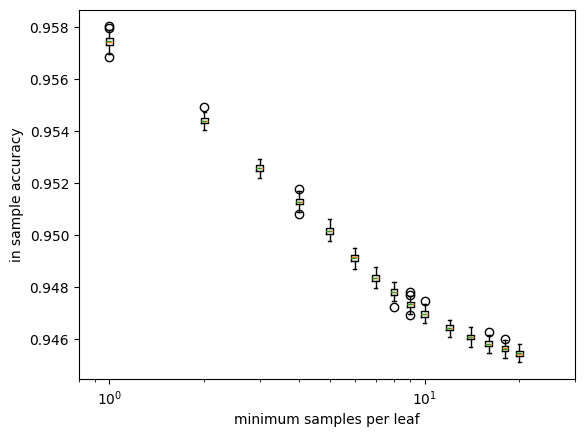

In [88]:
plt.figure()

df_select = df[df['features'] == 'sqrt']

positions = []
x = []

for min_samples_leaf_ in sorted(df_select['min_samples_leaf'].unique()):
    x.append(
        df_select[df_select['min_samples_leaf'] == min_samples_leaf_]['accuracy_in_sample']
    )
    positions.append(
        min_samples_leaf_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.05 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=30)
plt.xlabel('minimum samples per leaf')
plt.ylabel('in sample accuracy')

None

# Plot features = 'none' in sample accuracy

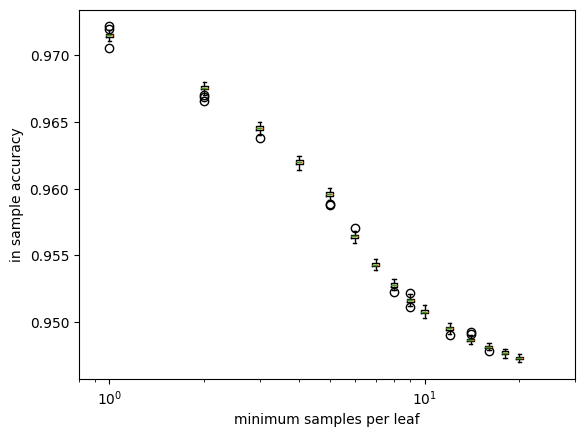

In [89]:
plt.figure()

df_select = df[df['features'] == 'none']

positions = []
x = []

for min_samples_leaf_ in sorted(df_select['min_samples_leaf'].unique()):
    x.append(
        df_select[df_select['min_samples_leaf'] == min_samples_leaf_]['accuracy_in_sample']
    )
    positions.append(
        min_samples_leaf_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.05 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=30)
plt.xlabel('minimum samples per leaf')
plt.ylabel('in sample accuracy')

None

# Plot features = 'sqrt' out of sample accuracy

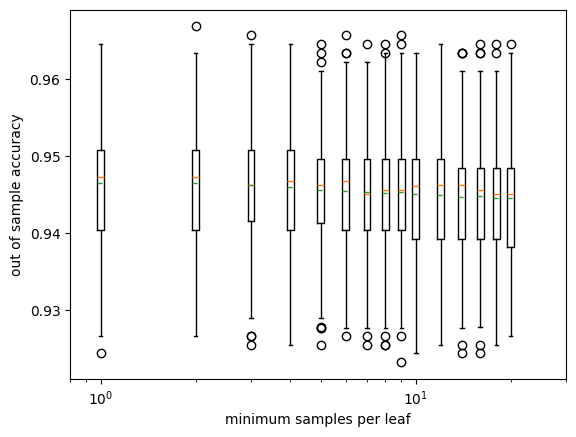

In [90]:
plt.figure()

df_select = df[df['features'] == 'sqrt']

positions = []
x = []

for min_samples_leaf_ in sorted(df_select['min_samples_leaf'].unique()):
    x.append(
        df_select[df_select['min_samples_leaf'] == min_samples_leaf_]['accuracy_out_of_sample']
    )
    positions.append(
        min_samples_leaf_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.05 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=30)
plt.xlabel('minimum samples per leaf')
plt.ylabel('out of sample accuracy')

None

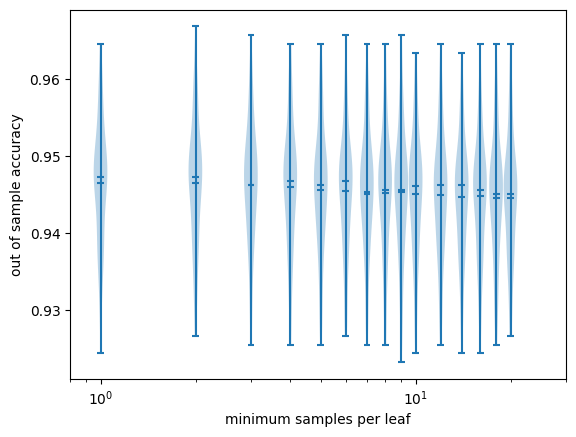

In [91]:
# violin plot

plt.figure()

df_select = df[df['features'] == 'sqrt']

positions = []
x = []

for min_samples_leaf_ in sorted(df_select['min_samples_leaf'].unique()):
    x.append(
        df_select[df_select['min_samples_leaf'] == min_samples_leaf_]['accuracy_out_of_sample']
    )
    positions.append(
        min_samples_leaf_
    )

plt.violinplot(
    x,
    positions=positions,
    orientation='vertical',
    widths=[0.1 * position for position in positions],
    showmeans=True,
    showmedians=True,
    showextrema=True,
    #quantiles=[0.25,0.75],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=30)
plt.xlabel('minimum samples per leaf')
plt.ylabel('out of sample accuracy')

None

# Plot features = 'none' out of sample accuracy

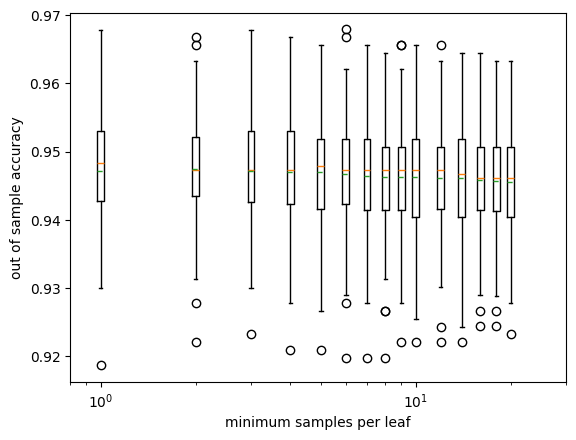

In [92]:
plt.figure()

df_select = df[df['features'] == 'none']

positions = []
x = []

for min_samples_leaf_ in sorted(df_select['min_samples_leaf'].unique()):
    x.append(
        df_select[df_select['min_samples_leaf'] == min_samples_leaf_]['accuracy_out_of_sample']
    )
    positions.append(
        min_samples_leaf_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.05 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=30)
plt.xlabel('minimum samples per leaf')
plt.ylabel('out of sample accuracy')

None

# Plot features = 'sqrt' out of bag accuracy

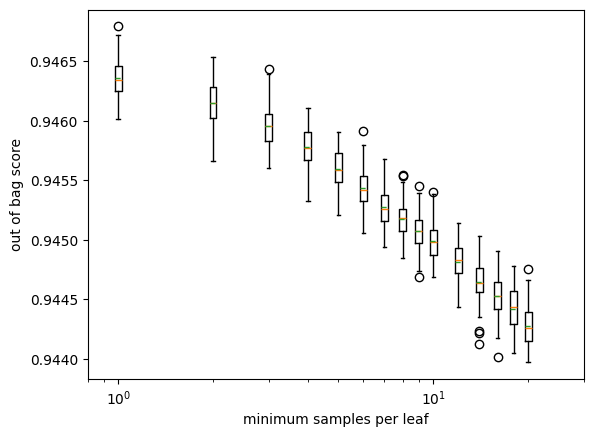

In [93]:
plt.figure()

df_select = df[df['features'] == 'sqrt']

positions = []
x = []

for min_samples_leaf_ in sorted(df_select['min_samples_leaf'].unique()):
    x.append(
        df_select[df_select['min_samples_leaf'] == min_samples_leaf_]['oob_score']
    )
    positions.append(
        min_samples_leaf_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.05 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=30)
plt.xlabel('minimum samples per leaf')
plt.ylabel('out of bag score')

None

# Plot features = 'none' out of bag accuracy

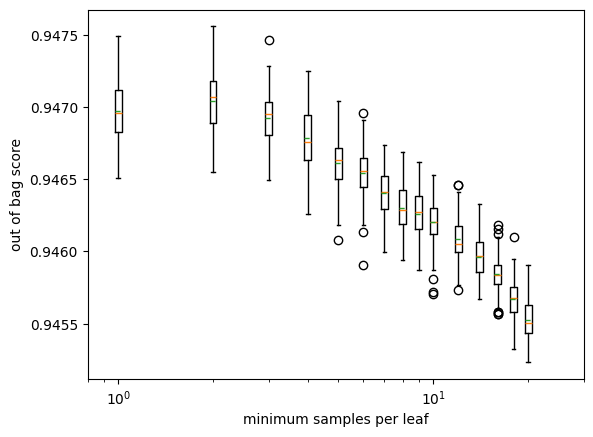

In [94]:
plt.figure()

df_select = df[df['features'] == 'none']

positions = []
x = []

for min_samples_leaf_ in sorted(df_select['min_samples_leaf'].unique()):
    x.append(
        df_select[df_select['min_samples_leaf'] == min_samples_leaf_]['oob_score']
    )
    positions.append(
        min_samples_leaf_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.05 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=30)
plt.xlabel('minimum samples per leaf')
plt.ylabel('out of bag score')

None

# Plot features = 'sqrt' in sample accuracy (lines)

In [95]:
df_select = df_aggregated[df_aggregated['features'] == 'sqrt']

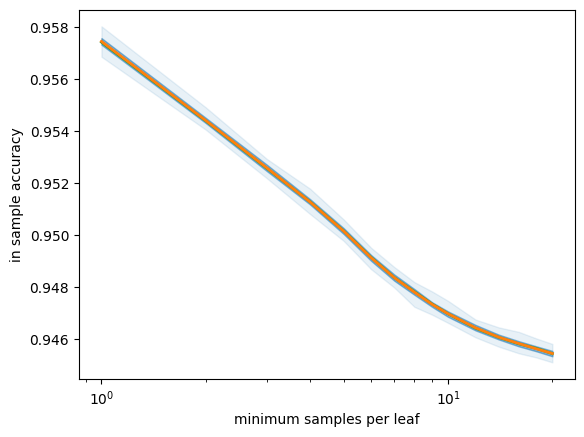

In [96]:
plt.figure()

plt.fill_between(
    df_select['min_samples_leaf'],
    df_select['accuracy_in_sample_min'],
    df_select['accuracy_in_sample_max'],
    color='tab:blue',
    alpha=0.1,
    label='range',
)

plt.fill_between(
    df_select['min_samples_leaf'],
    df_select['accuracy_in_sample_q1'],
    df_select['accuracy_in_sample_q3'],
    color='tab:blue',
    alpha=0.5,
    label='range',
)

plt.plot(
    df_select['min_samples_leaf'],
    df_select['accuracy_in_sample_median'],
    color='tab:green',
    label='median',
    linewidth=2,
)

plt.plot(
    df_select['min_samples_leaf'],
    df_select['accuracy_in_sample_mean'],
    color='tab:orange',
    label='mean',
    linewidth=2,
)

plt.xscale('log')
#plt.xlim(xmin=0.8, xmax=120)
plt.xlabel('minimum samples per leaf')
plt.ylabel('in sample accuracy')

None

# Plot features = 'sqrt' out of sample accuracy (lines)

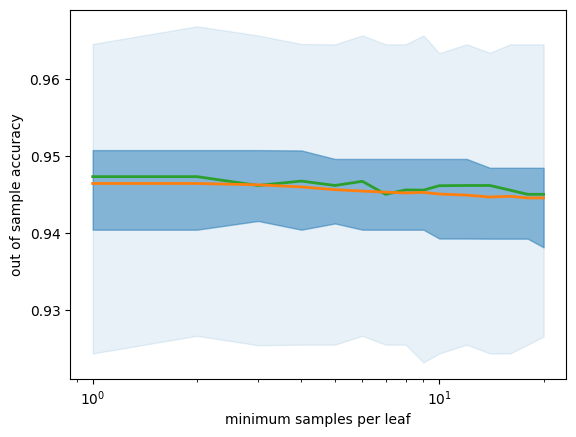

In [97]:
plt.figure()

plt.fill_between(
    df_select['min_samples_leaf'],
    df_select['accuracy_out_of_sample_min'],
    df_select['accuracy_out_of_sample_max'],
    color='tab:blue',
    alpha=0.1,
    label='range',
)

plt.fill_between(
    df_select['min_samples_leaf'],
    df_select['accuracy_out_of_sample_q1'],
    df_select['accuracy_out_of_sample_q3'],
    color='tab:blue',
    alpha=0.5,
    label='range',
)

plt.plot(
    df_select['min_samples_leaf'],
    df_select['accuracy_out_of_sample_median'],
    color='tab:green',
    label='median',
    linewidth=2,
)

plt.plot(
    df_select['min_samples_leaf'],
    df_select['accuracy_out_of_sample_mean'],
    color='tab:orange',
    label='mean',
    linewidth=2,
)

plt.xscale('log')
#plt.xlim(xmin=0.8, xmax=120)
plt.xlabel('minimum samples per leaf')
plt.ylabel('out of sample accuracy')

None

# Plot features = 'sqrt' out of bag accuracy (lines)

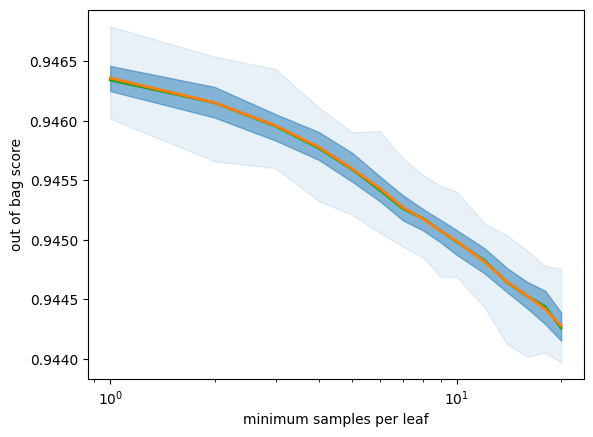

In [98]:
plt.figure()

plt.fill_between(
    df_select['min_samples_leaf'],
    df_select['oob_score_min'],
    df_select['oob_score_max'],
    color='tab:blue',
    alpha=0.1,
    label='range',
)

plt.fill_between(
    df_select['min_samples_leaf'],
    df_select['oob_score_q1'],
    df_select['oob_score_q3'],
    color='tab:blue',
    alpha=0.5,
    label='range',
)

plt.plot(
    df_select['min_samples_leaf'],
    df_select['oob_score_median'],
    color='tab:green',
    label='median',
    linewidth=2,
)

plt.plot(
    df_select['min_samples_leaf'],
    df_select['oob_score_mean'],
    color='tab:orange',
    label='mean',
    linewidth=2,
)

plt.xscale('log')
#plt.xlim(xmin=0.8, xmax=120)
plt.xlabel('minimum samples per leaf')
plt.ylabel('out of bag score')

None

# Plot features = 'log2' in sample accuracy

In [95]:
# don't need every possible graph style this time